In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================
# 1. LOAD DATA
# ============================================
print("="*60)
print("LOADING DATA")
print("="*60)

df = pd.read_csv('men_2026_matchups_training.csv')

# Filter for First Round
rounds_of_interest = ['First Round']
df_filtered = df[df['round'].isin(rounds_of_interest)].copy()

print(f"Original Dataset Shape: {df.shape}")
print(f"Filtered Dataset Shape: {df_filtered.shape}")
print(f"\nRound Distribution:")
print(df_filtered['round'].value_counts())
print(f"\nTarget Variable Distribution:")
print(df_filtered['win'].value_counts())
print(f"Win Rate: {df_filtered['win'].mean():.2%}")

# ============================================
# 2. PREPARE FEATURES (EXCLUDING SEEDS)
# ============================================
print("\n" + "="*60)
print("PREPARING FEATURES")
print("="*60)

exclude_cols = ['Unnamed: 0', 'game_id', 'year', 'region', 'round',
                'high_bracket_team', 'low_bracket_team', 'win',
                'high_bracket_seed', 'low_bracket_seed']
feature_cols = [col for col in df_filtered.columns if col not in exclude_cols]

X = df_filtered[feature_cols].copy()
y = df_filtered['win'].copy()

# Clean data
X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)

print(f"Feature Matrix Shape: {X.shape}")
print(f"Number of Features: {X.shape[1]}")

# ============================================
# 3. TRAIN/TEST SPLIT
# ============================================
print("\n" + "="*60)
print("TRAIN/TEST SPLIT")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training win rate: {y_train.mean():.2%}")
print(f"Test win rate: {y_test.mean():.2%}")

LOADING DATA
Original Dataset Shape: (1254, 118)
Filtered Dataset Shape: (636, 118)

Round Distribution:
round
First Round    636
Name: count, dtype: int64

Target Variable Distribution:
win
1    318
0    318
Name: count, dtype: int64
Win Rate: 50.00%

PREPARING FEATURES
Feature Matrix Shape: (636, 108)
Number of Features: 108

TRAIN/TEST SPLIT
Training set size: 508
Test set size: 128
Training win rate: 50.00%
Test win rate: 50.00%



EXPLORATORY DATA ANALYSIS

--- Top 20 Features Correlated with Winning ---
                       Feature  Correlation
                      5man_bpm     0.545658
                    kenpom_rtg     0.539301
                    torvik_rtg     0.539086
                      3man_bpm     0.530245
                           wab     0.514796
                     5man_dbpm     0.500142
                     5man_obpm     0.495807
                    torvik_off     0.464774
                    torvik_def     0.462816
                     3man_dbpm     0.460989
                    kenpom_def     0.459242
                    kenpom_off     0.457080
                     3man_obpm     0.451816
          lineup_depth_quality    -0.438982
         def_experience_impact     0.436080
experience_weighted_production     0.435621
      def_lineup_depth_quality    -0.424865
                          size     0.323373
    def_four_factors_composite     0.262200
        four_factors_composite     0.258046


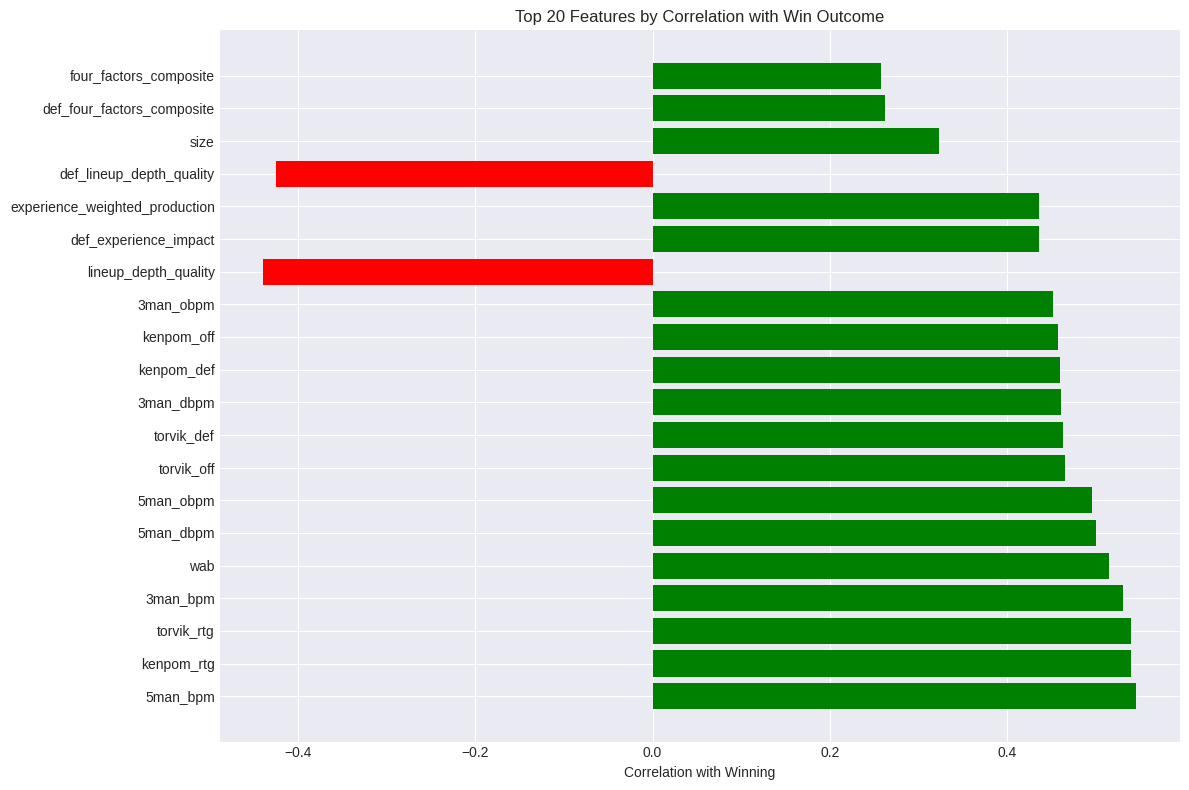

In [2]:
# ============================================
# 4. EXPLORATORY DATA ANALYSIS
# ============================================
print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# Feature correlations with target (using training data only)
print("\n--- Top 20 Features Correlated with Winning ---")
correlations = pd.DataFrame({
    'Feature': X_train.columns,
    'Correlation': [X_train[col].corr(y_train) for col in X_train.columns]
})
correlations['Abs_Correlation'] = correlations['Correlation'].abs()
top_correlations = correlations.nlargest(20, 'Abs_Correlation')
print(top_correlations[['Feature', 'Correlation']].to_string(index=False))

# Plot 1: Top correlations
plt.figure(figsize=(12, 8))
top_20 = correlations.nlargest(20, 'Abs_Correlation')
colors = ['green' if x > 0 else 'red' for x in top_20['Correlation']]
plt.barh(range(len(top_20)), top_20['Correlation'], color=colors)
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Correlation with Winning')
plt.title('Top 20 Features by Correlation with Win Outcome')
plt.tight_layout()
plt.show()

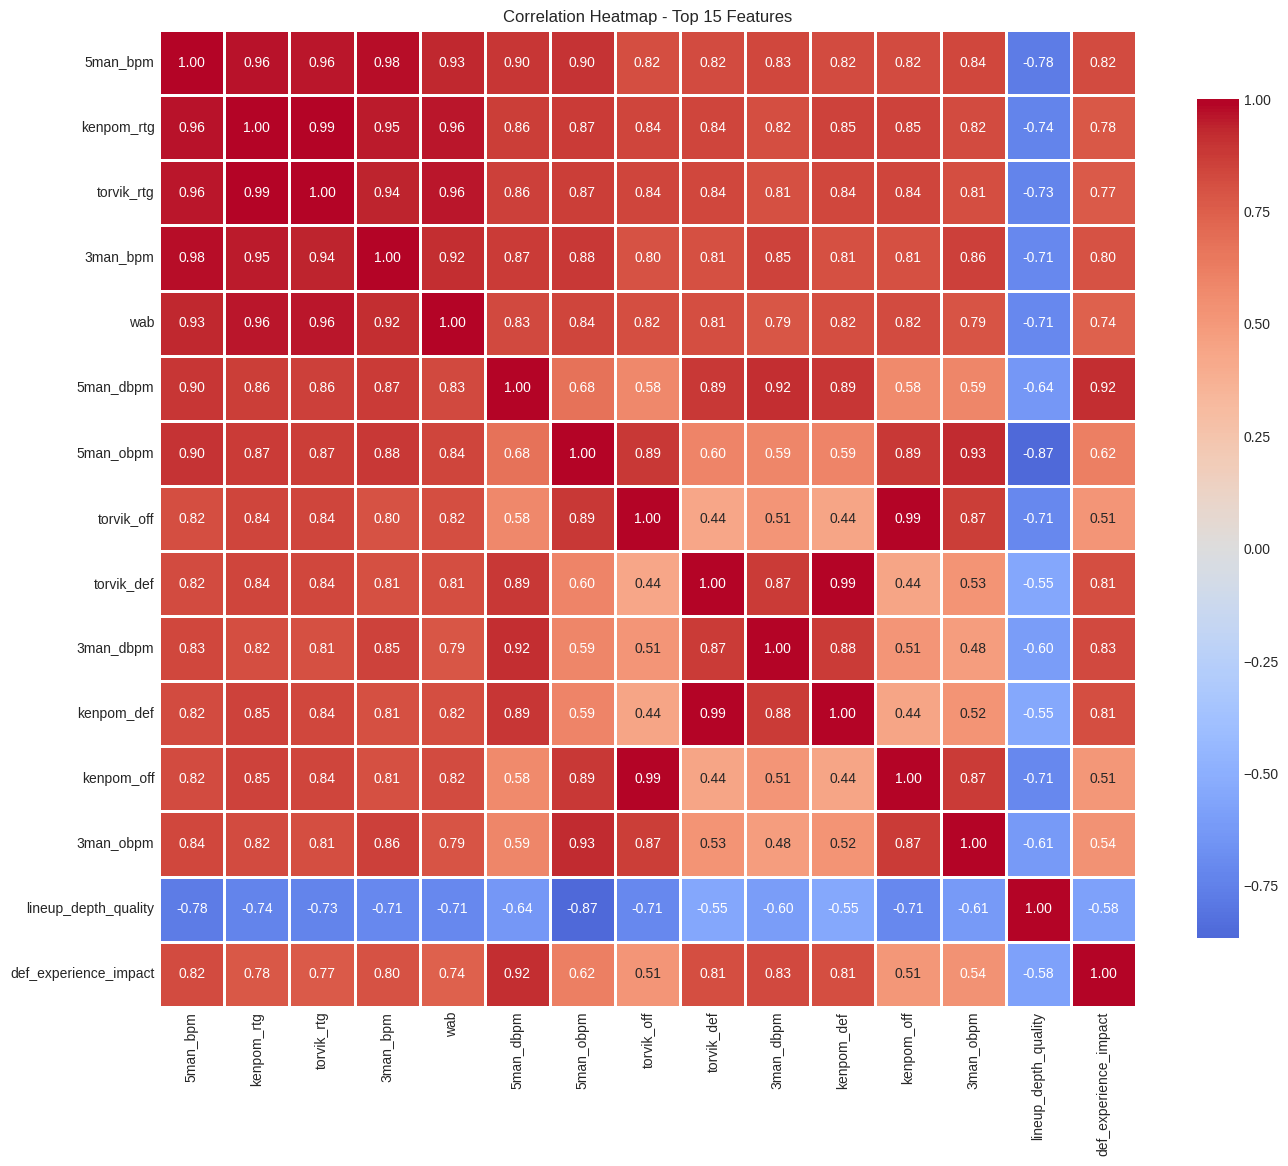

In [3]:
# Plot 2: Feature correlation heatmap (top features)
plt.figure(figsize=(14, 12))
top_features = top_20['Feature'].head(15).tolist()
corr_matrix = X_train[top_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Top 15 Features')
plt.tight_layout()
plt.show()

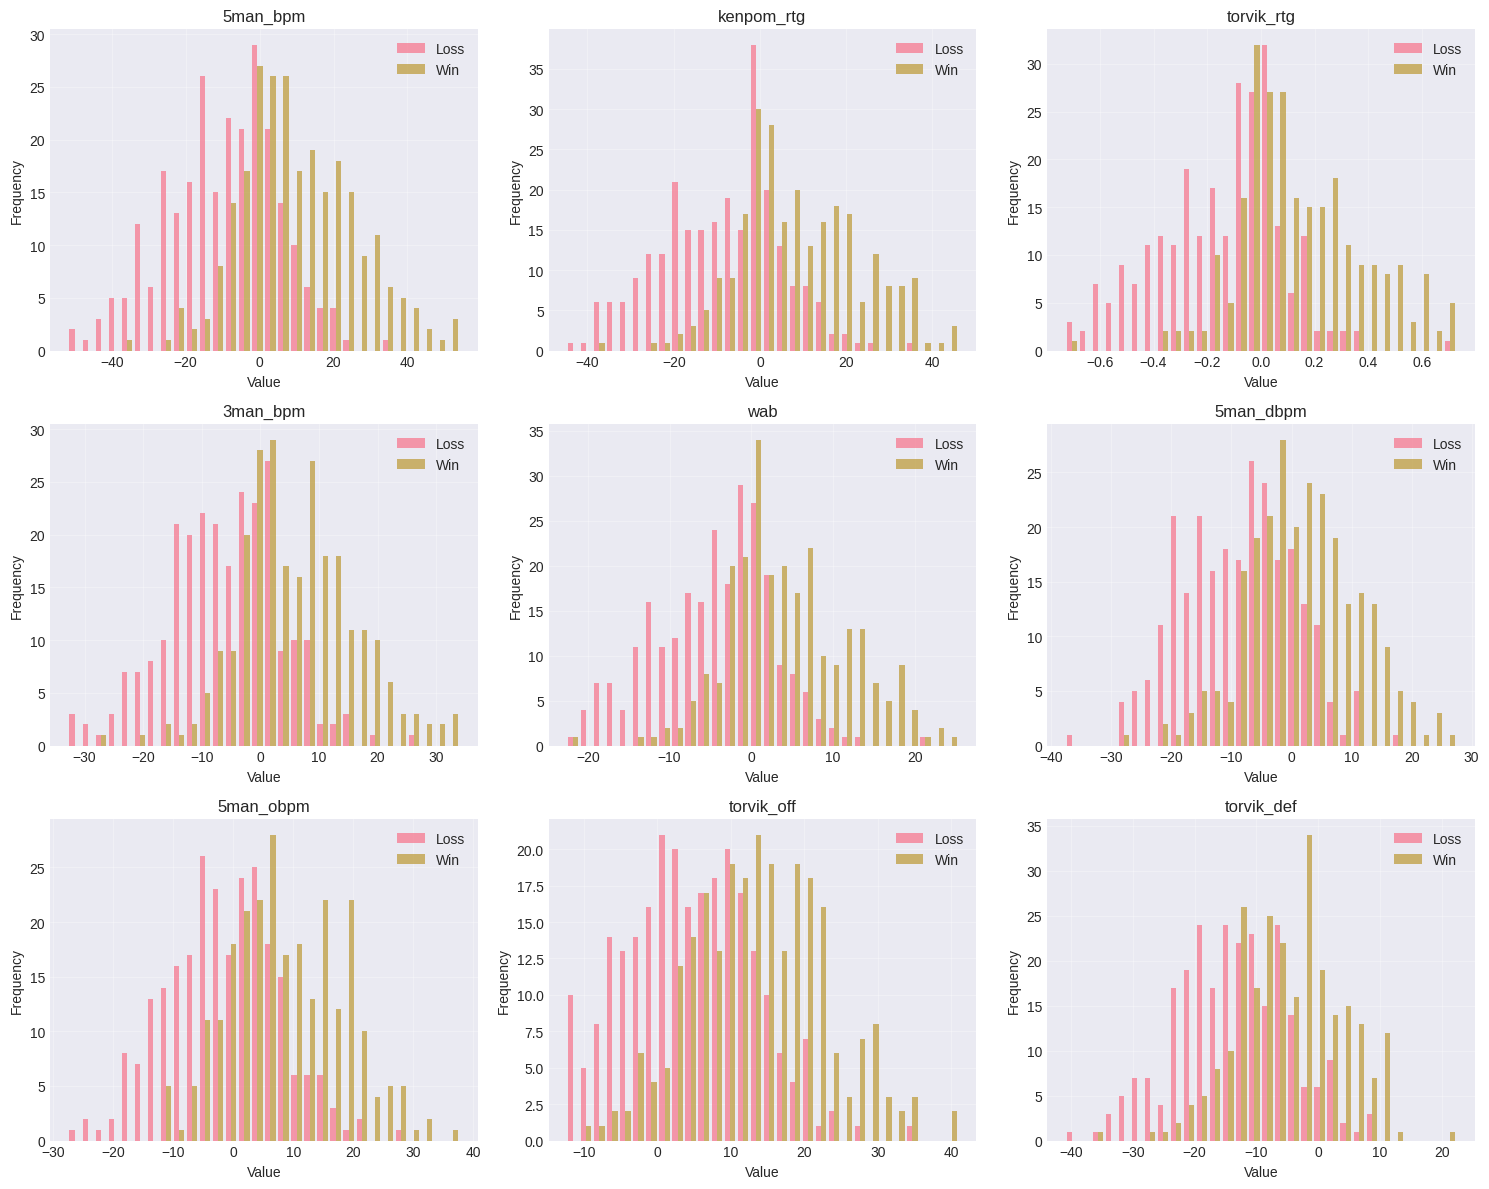

In [4]:
# Plot 3: Feature distributions for top features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, feat in enumerate(top_features[:9]):
    axes[idx].hist([X_train[feat][y_train==0], X_train[feat][y_train==1]],
                  bins=30, alpha=0.7, label=['Loss', 'Win'])
    axes[idx].set_title(f'{feat}')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# Statistical summary
print("\n--- Statistical Summary of Top 10 Features ---")
print(X_train[top_features[:10]].describe().T[['mean', 'std', 'min', 'max']])


--- Statistical Summary of Top 10 Features ---
                mean        std        min        max
5man_bpm    0.096654  18.436659 -51.800000  54.100000
kenpom_rtg  0.067158  16.779915 -44.823980  45.944660
torvik_rtg  0.000187   0.277453  -0.729094   0.729094
3man_bpm    0.074606  11.575277 -32.800000  34.000000
wab         0.007502   8.588787 -22.594104  25.303699
5man_dbpm  -3.464961  10.720115 -37.700000  27.500000
5man_obpm   3.654921  10.791979 -27.500000  37.700000
torvik_off  9.164772  10.107241 -12.367708  40.942976
torvik_def -9.081468  10.003900 -40.942976  22.397082
3man_dbpm  -5.319685   6.797981 -27.400000  16.200000


In [6]:
# ============================================
# 5. FEATURE SELECTION METHODS (ON TRAINING DATA) - TOP 40
# ============================================
print("\n" + "="*60)
print("FEATURE SELECTION METHODS - TOP 40")
print("="*60)

# 5.1 Univariate Feature Selection (ANOVA F-test)
print("\n--- Univariate Feature Selection (ANOVA F-test) ---")
k = 40
selector_uni = SelectKBest(score_func=f_classif, k=k)
selector_uni.fit(X_train, y_train)

univariate_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': selector_uni.scores_,
    'P_value': selector_uni.pvalues_
}).sort_values('Score', ascending=False)

univariate_features = univariate_scores.head(k)['Feature'].tolist()
print(f"\nTop {k} features selected:")
print(univariate_scores.head(k)[['Feature', 'Score']].to_string(index=False))


FEATURE SELECTION METHODS - TOP 40

--- Univariate Feature Selection (ANOVA F-test) ---

Top 40 features selected:
                       Feature      Score
                      5man_bpm 214.533161
                    kenpom_rtg 207.526233
                    torvik_rtg 207.292782
                      3man_bpm 197.912024
                           wab 182.449036
                     5man_dbpm 168.794389
                     5man_obpm 164.931650
                    torvik_off 139.420271
                    torvik_def 137.928543
                     3man_dbpm 136.548541
                    kenpom_def 135.239607
                    kenpom_off 133.633477
                     3man_obpm 129.788302
          lineup_depth_quality 120.784421
         def_experience_impact 118.819204
experience_weighted_production 118.510764
      def_lineup_depth_quality 111.457463
                          size  59.091653
    def_four_factors_composite  37.355100
        four_factors_composite  36.097053
  

In [7]:
# 5.2 Mutual Information Feature Selection
print("\n--- Mutual Information Feature Selection ---")
selector_mi = SelectKBest(score_func=mutual_info_classif, k=k)
selector_mi.fit(X_train, y_train)

mi_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'MI_Score': selector_mi.scores_
}).sort_values('MI_Score', ascending=False)

mi_features = mi_scores.head(k)['Feature'].tolist()
print(f"\nTop {k} features selected:")
print(mi_scores.head(k).to_string(index=False))


--- Mutual Information Feature Selection ---

Top 40 features selected:
                       Feature  MI_Score
                      5man_bpm  0.191502
                      3man_bpm  0.187783
                           wab  0.177098
                    torvik_rtg  0.176688
                    kenpom_rtg  0.167001
                    kenpom_def  0.143659
                    torvik_def  0.138502
                     5man_dbpm  0.135763
                     3man_dbpm  0.135614
                    torvik_off  0.129778
                    kenpom_off  0.127227
                     5man_obpm  0.127104
experience_weighted_production  0.118627
                     3man_obpm  0.110827
         def_experience_impact  0.102102
      def_lineup_depth_quality  0.100026
          lineup_depth_quality  0.092359
                           tor  0.058566
    def_four_factors_composite  0.049412
         assist_to_usage_ratio  0.048947
        four_factors_composite  0.047913
             def_close2_f


--- Random Forest Feature Importance ---

Top 40 features by importance:
                       Feature  Importance
                      3man_bpm    0.053067
                      5man_bpm    0.039678
                     3man_dbpm    0.034397
                           wab    0.033530
                    torvik_rtg    0.033235
                    kenpom_rtg    0.028584
                     5man_obpm    0.026290
                     5man_dbpm    0.024249
                    torvik_def    0.019566
experience_weighted_production    0.019147
                     3man_obpm    0.018626
                    kenpom_off    0.018202
                    torvik_off    0.017244
                      astd_pct    0.014097
      def_lineup_depth_quality    0.013409
           bench_scoring_ratio    0.012671
                         bench    0.011934
                          size    0.011762
               tempo_advantage    0.011263
                       ast_pct    0.011181
                     ad

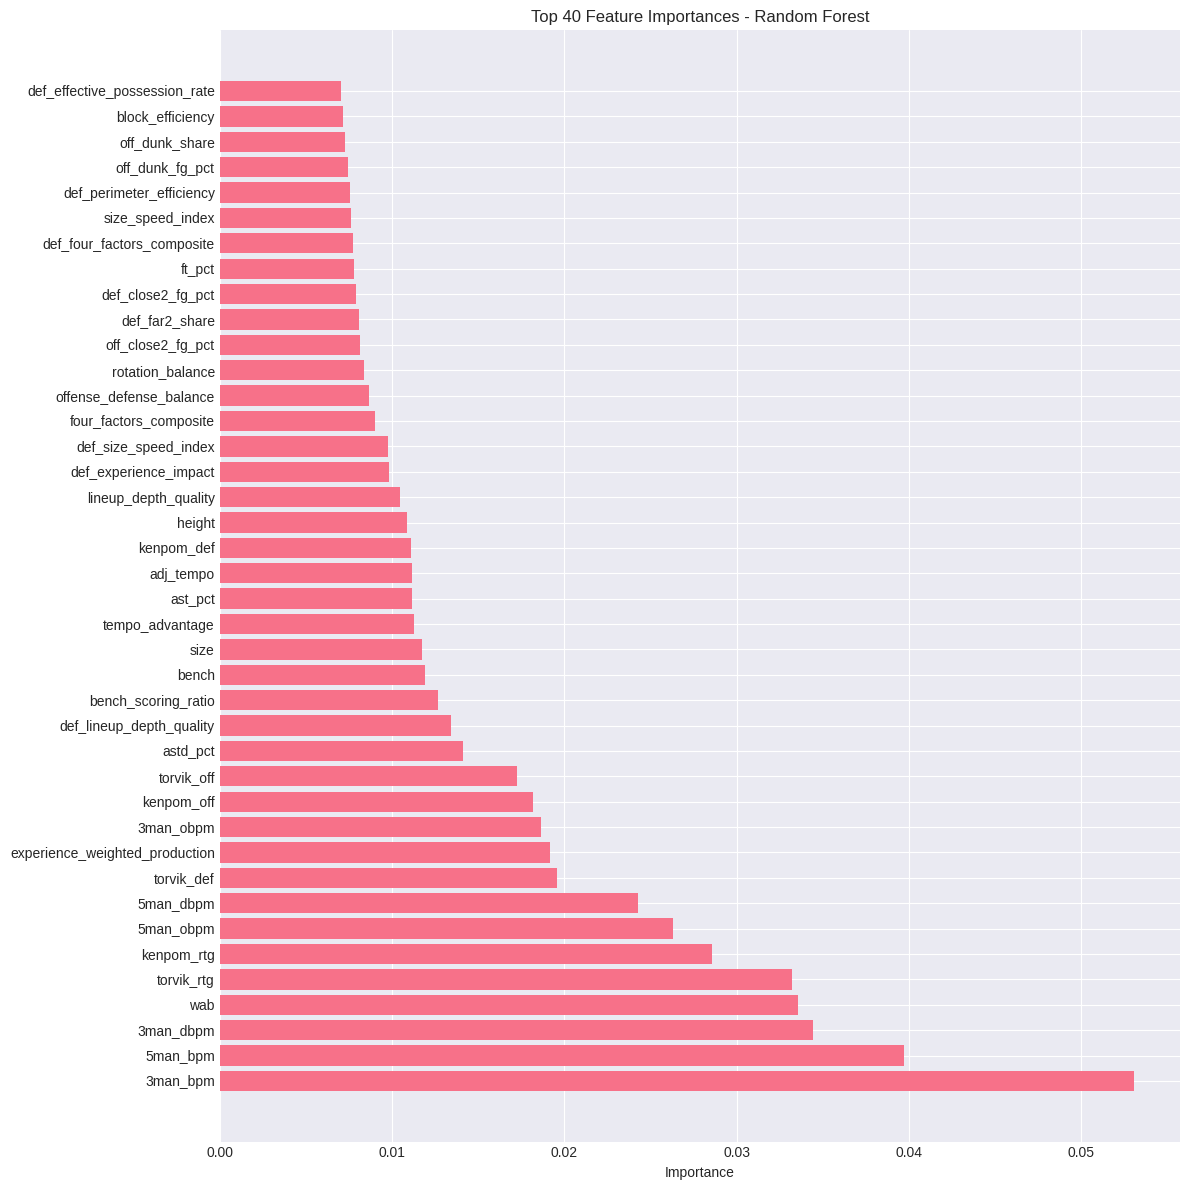

In [8]:
# 5.3 Random Forest Feature Importance
print("\n--- Random Forest Feature Importance ---")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train, y_train)

rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_selector.feature_importances_
}).sort_values('Importance', ascending=False)

rf_top_features = rf_importance.head(40)['Feature'].tolist()
print(f"\nTop 40 features by importance:")
print(rf_importance.head(40).to_string(index=False))

# Plot RF feature importance
plt.figure(figsize=(12, 12))
top_40_rf = rf_importance.head(40)
plt.barh(range(len(top_40_rf)), top_40_rf['Importance'])
plt.yticks(range(len(top_40_rf)), top_40_rf['Feature'])
plt.xlabel('Importance')
plt.title('Top 40 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()


--- Logistic Regression Feature Importance ---

Top 40 features by importance:
                      Feature  Importance
                     5man_bpm    0.733686
                   torvik_rtg    0.576337
    elite_outcome_probability    0.215820
                    5man_dbpm    0.190364
             paint_touch_rate    0.122630
                        bench    0.109576
            def_close2_fg_pct    0.093200
          bench_scoring_ratio    0.075471
                    adj_tempo    0.073756
                   experience    0.066547
         lineup_depth_quality    0.061549
                    5man_obpm    0.059386
                       height    0.056588
            off_close2_fg_pct    0.052012
         def_paint_touch_rate    0.048250
              tempo_advantage    0.038712
       def_mid_range_reliance    0.034971
                   torvik_off    0.015050
top5_rebounding_concentration    0.011327
                def_3pt_share    0.008184
           mid_range_reliance    0.005

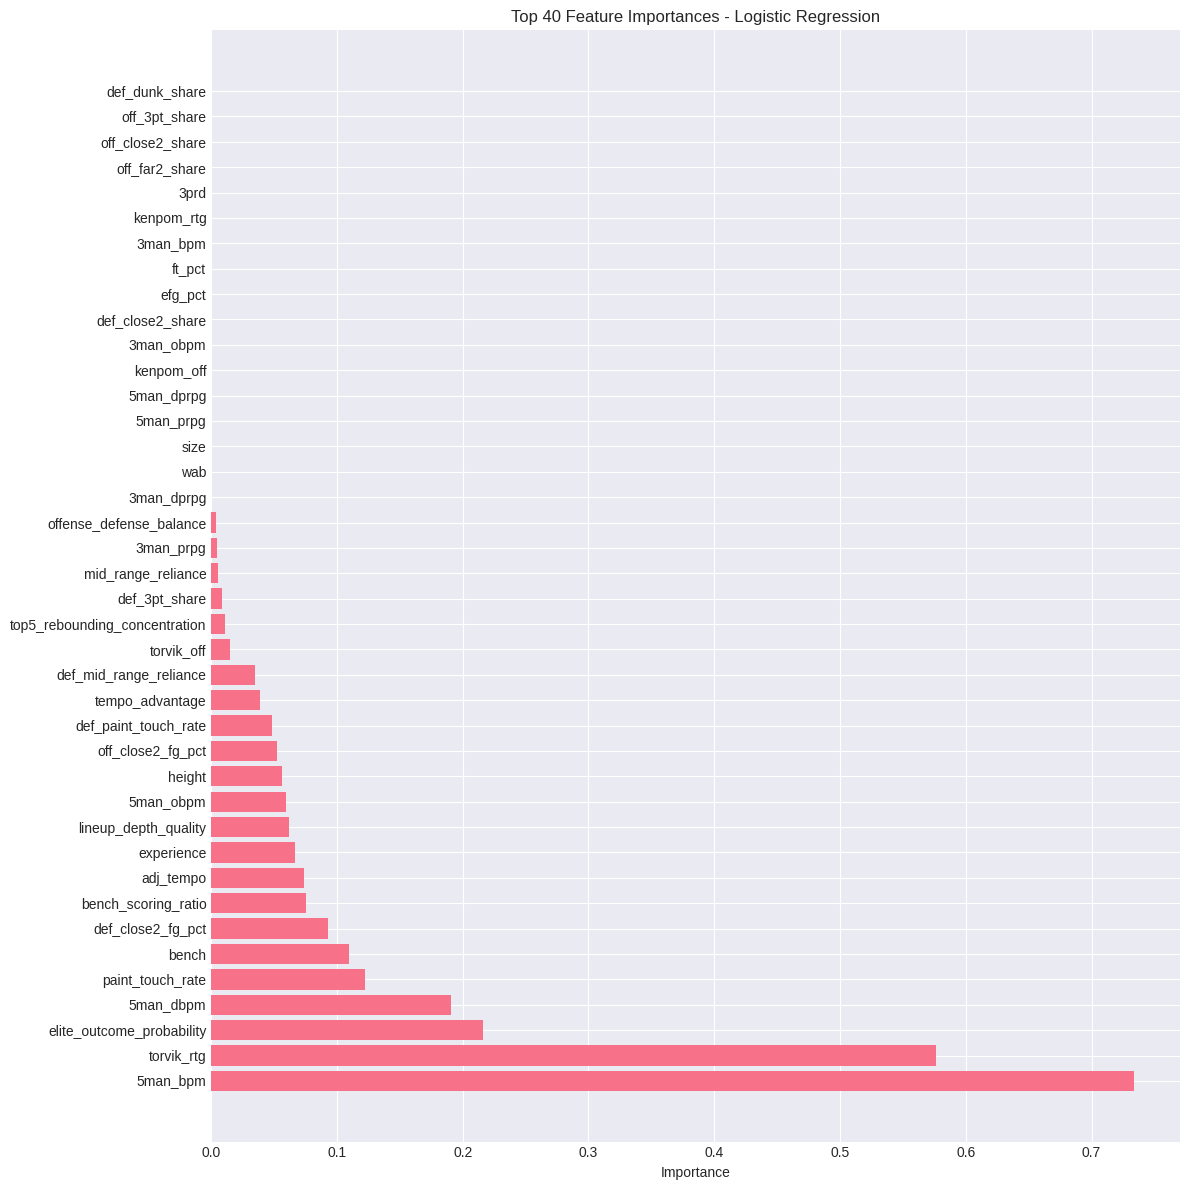

In [9]:
# 5.4 Logistic Regression Feature Importance
print("\n--- Logistic Regression Feature Importance ---")
scaler_temp = StandardScaler()
X_train_scaled_temp = scaler_temp.fit_transform(X_train)

lr_selector = LogisticRegression(max_iter=1000, random_state=42, penalty='l1',
                                 solver='liblinear', C=0.1)
lr_selector.fit(X_train_scaled_temp, y_train)

lr_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(lr_selector.coef_[0])
}).sort_values('Importance', ascending=False)

lr_top_features = lr_importance.head(40)['Feature'].tolist()
print(f"\nTop 40 features by importance:")
print(lr_importance.head(40).to_string(index=False))

# Plot LR feature importance
plt.figure(figsize=(12, 12))
top_40_lr = lr_importance.head(40)
plt.barh(range(len(top_40_lr)), top_40_lr['Importance'])
plt.yticks(range(len(top_40_lr)), top_40_lr['Feature'])
plt.xlabel('Importance')
plt.title('Top 40 Feature Importances - Logistic Regression')
plt.tight_layout()
plt.show()

In [10]:
# 5.5 Recursive Feature Elimination (RFE)
print("\n--- Recursive Feature Elimination (RFE) ---")
rfe_estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
selector_rfe = RFE(estimator=rfe_estimator, n_features_to_select=40, step=5)
selector_rfe.fit(X_train, y_train)

rfe_rankings = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': selector_rfe.ranking_,
    'Selected': selector_rfe.support_
}).sort_values('Ranking')

rfe_features = rfe_rankings[rfe_rankings['Selected']]['Feature'].tolist()
print(f"\nTop 40 features selected:")
print(rfe_rankings.head(40)[['Feature', 'Ranking']].to_string(index=False))

# Top correlation features
correlation_features = correlations.nlargest(40, 'Abs_Correlation')['Feature'].tolist()


--- Recursive Feature Elimination (RFE) ---

Top 40 features selected:
                       Feature  Ranking
                      5man_bpm        1
                      3man_bpm        1
                           wab        1
                    kenpom_rtg        1
                    torvik_rtg        1
                     adj_tempo        1
                          size        1
                    3man_dprpg        1
                         bench        1
                     3man_obpm        1
                    kenpom_off        1
                    torvik_off        1
                     5man_obpm        1
              def_close2_share        1
                off_far2_share        1
                          3prd        1
                          tord        1
                off_3pt_fg_pct        1
                     3man_dbpm        1
                    kenpom_def        1
                    torvik_def        1
                     5man_dbpm        1
        

In [11]:
# ============================================
# 6. MODEL COMPARISON WITH DIFFERENT FEATURE SETS
# ============================================
print("\n" + "="*60)
print("MODEL COMPARISON WITH DIFFERENT FEATURE SETS")
print("="*60)

# Define feature sets
feature_sets = {
    'Top_40_Correlation': correlation_features,
    'Univariate_F_Test': univariate_features,
    'Mutual_Information': mi_features,
    'RF_Importance': rf_top_features,
    'LR_Importance': lr_top_features,
    'RFE_Selected': rfe_features,
    'All_Features': X_train.columns.tolist()
}

results_summary = []

for set_name, features in feature_sets.items():
    print(f"\n{'#'*60}")
    print(f"FEATURE SET: {set_name} ({len(features)} features)")
    print(f"{'#'*60}")

    # Prepare data subsets
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]

    # Scale for Logistic Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_subset)
    X_test_scaled = scaler.transform(X_test_subset)

    # === Random Forest ===
    print(f"\n--- Random Forest - {set_name} ---")
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train_subset, y_train)

    # RF Predictions
    rf_y_pred = rf_model.predict(X_test_subset)
    rf_y_pred_proba = rf_model.predict_proba(X_test_subset)[:, 1]

    # RF Metrics
    rf_accuracy = accuracy_score(y_test, rf_y_pred)
    rf_cv_scores = cross_val_score(rf_model, X_train_subset, y_train, cv=5, scoring='accuracy')
    rf_cv_mean = rf_cv_scores.mean()
    rf_cv_std = rf_cv_scores.std()

    try:
        rf_auc = roc_auc_score(y_test, rf_y_pred_proba)
    except:
        rf_auc = None

    print(f"Test Accuracy: {rf_accuracy:.4f}")
    print(f"Cross-Validation Accuracy: {rf_cv_mean:.4f} (+/- {rf_cv_std:.4f})")
    if rf_auc:
        print(f"ROC AUC Score: {rf_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, rf_y_pred, target_names=['Loss', 'Win']))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, rf_y_pred))

    # === Logistic Regression ===
    print(f"\n--- Logistic Regression - {set_name} ---")
    lr_model = LogisticRegression(
        max_iter=1000,
        random_state=42,
        C=1.0,
        penalty='l2'
    )
    lr_model.fit(X_train_scaled, y_train)

    # LR Predictions
    lr_y_pred = lr_model.predict(X_test_scaled)
    lr_y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

    # LR Metrics
    lr_accuracy = accuracy_score(y_test, lr_y_pred)
    lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    lr_cv_mean = lr_cv_scores.mean()
    lr_cv_std = lr_cv_scores.std()

    try:
        lr_auc = roc_auc_score(y_test, lr_y_pred_proba)
    except:
        lr_auc = None

    print(f"Test Accuracy: {lr_accuracy:.4f}")
    print(f"Cross-Validation Accuracy: {lr_cv_mean:.4f} (+/- {lr_cv_std:.4f})")
    if lr_auc:
        print(f"ROC AUC Score: {lr_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, lr_y_pred, target_names=['Loss', 'Win']))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, lr_y_pred))

    # Store results
    results_summary.append({
        'Feature_Set': set_name,
        'Num_Features': len(features),
        'RF_Test_Accuracy': rf_accuracy,
        'RF_CV_Mean': rf_cv_mean,
        'RF_CV_Std': rf_cv_std,
        'LR_Test_Accuracy': lr_accuracy,
        'LR_CV_Mean': lr_cv_mean,
        'LR_CV_Std': lr_cv_std
    })


MODEL COMPARISON WITH DIFFERENT FEATURE SETS

############################################################
FEATURE SET: Top_40_Correlation (40 features)
############################################################

--- Random Forest - Top_40_Correlation ---
Test Accuracy: 0.7656
Cross-Validation Accuracy: 0.7244 (+/- 0.0095)
ROC AUC Score: 0.8779

Classification Report:
              precision    recall  f1-score   support

        Loss       0.77      0.77      0.77        64
         Win       0.77      0.77      0.77        64

    accuracy                           0.77       128
   macro avg       0.77      0.77      0.77       128
weighted avg       0.77      0.77      0.77       128


Confusion Matrix:
[[49 15]
 [15 49]]

--- Logistic Regression - Top_40_Correlation ---
Test Accuracy: 0.7891
Cross-Validation Accuracy: 0.7264 (+/- 0.0281)
ROC AUC Score: 0.8779

Classification Report:
              precision    recall  f1-score   support

        Loss       0.78      0.81      0.


FINAL MODEL COMPARISON SUMMARY
       Feature_Set  Num_Features  RF_Test_Accuracy  RF_CV_Mean  RF_CV_Std  LR_Test_Accuracy  LR_CV_Mean  LR_CV_Std
Top_40_Correlation            40          0.765625    0.724384   0.009475          0.789062    0.726364   0.028113
 Univariate_F_Test            40          0.765625    0.724384   0.009475          0.789062    0.726364   0.028113
Mutual_Information            40          0.757812    0.726383   0.014310          0.765625    0.722500   0.039016
     RF_Importance            40          0.781250    0.740206   0.023302          0.781250    0.728460   0.027824
     LR_Importance            40          0.796875    0.748049   0.016798          0.781250    0.750087   0.038150
      RFE_Selected            40          0.781250    0.740206   0.010638          0.804688    0.742186   0.023801
      All_Features           108          0.757812    0.712561   0.010646          0.765625    0.734285   0.033128


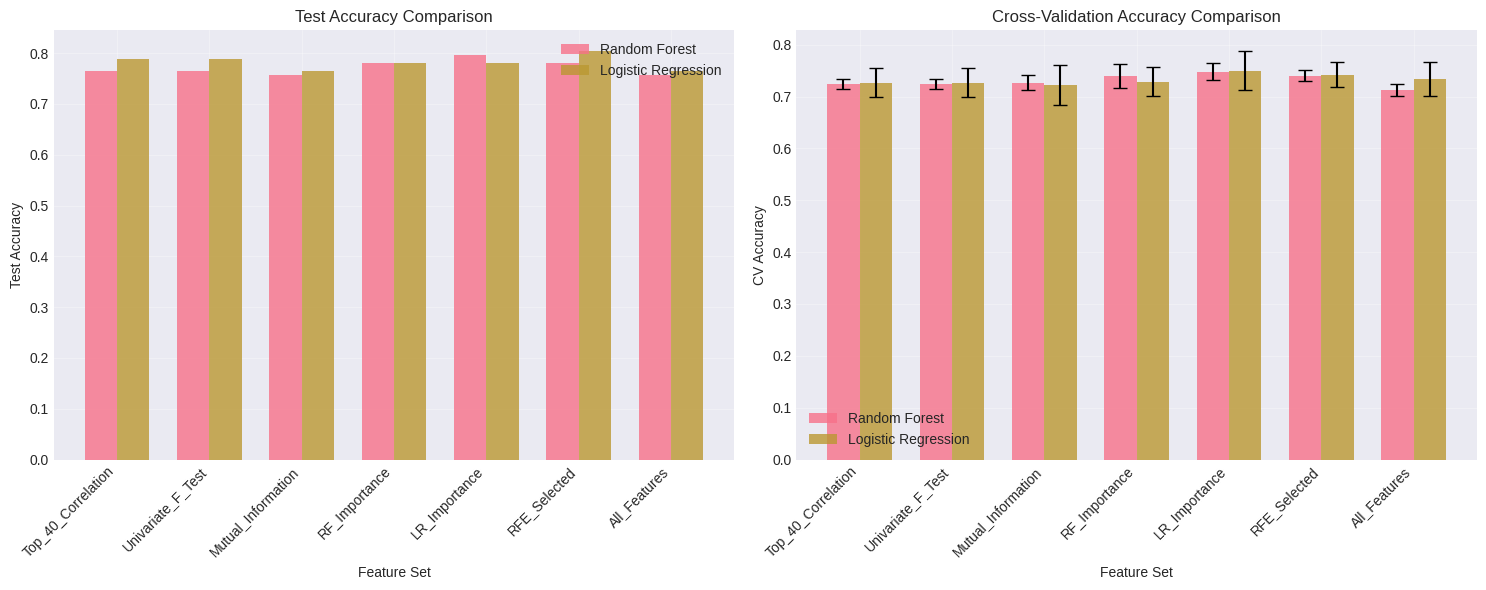


BEST PERFORMING CONFIGURATIONS

Best Random Forest:
  Feature Set: LR_Importance
  Test Accuracy: 0.7969
  CV Accuracy: 0.7480 (+/- 0.0168)

Best Logistic Regression:
  Feature Set: RFE_Selected
  Test Accuracy: 0.8047
  CV Accuracy: 0.7422 (+/- 0.0238)

ANALYSIS COMPLETE!


In [12]:
# ============================================
# 7. FINAL COMPARISON SUMMARY
# ============================================
results_df = pd.DataFrame(results_summary)

print("\n" + "="*60)
print("FINAL MODEL COMPARISON SUMMARY")
print("="*60)
print(results_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Test Accuracy Comparison
x_pos = np.arange(len(results_df))
width = 0.35

axes[0].bar(x_pos - width/2, results_df['RF_Test_Accuracy'], width,
            label='Random Forest', alpha=0.8)
axes[0].bar(x_pos + width/2, results_df['LR_Test_Accuracy'], width,
            label='Logistic Regression', alpha=0.8)
axes[0].set_xlabel('Feature Set')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Test Accuracy Comparison')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df['Feature_Set'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CV Accuracy Comparison
axes[1].bar(x_pos - width/2, results_df['RF_CV_Mean'], width,
            yerr=results_df['RF_CV_Std'], label='Random Forest',
            alpha=0.8, capsize=5)
axes[1].bar(x_pos + width/2, results_df['LR_CV_Mean'], width,
            yerr=results_df['LR_CV_Std'], label='Logistic Regression',
            alpha=0.8, capsize=5)
axes[1].set_xlabel('Feature Set')
axes[1].set_ylabel('CV Accuracy')
axes[1].set_title('Cross-Validation Accuracy Comparison')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results_df['Feature_Set'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best performing configurations
best_rf_idx = results_df['RF_Test_Accuracy'].idxmax()
best_lr_idx = results_df['LR_Test_Accuracy'].idxmax()

print("\n" + "="*60)
print("BEST PERFORMING CONFIGURATIONS")
print("="*60)
print(f"\nBest Random Forest:")
print(f"  Feature Set: {results_df.loc[best_rf_idx, 'Feature_Set']}")
print(f"  Test Accuracy: {results_df.loc[best_rf_idx, 'RF_Test_Accuracy']:.4f}")
print(f"  CV Accuracy: {results_df.loc[best_rf_idx, 'RF_CV_Mean']:.4f} "
      f"(+/- {results_df.loc[best_rf_idx, 'RF_CV_Std']:.4f})")

print(f"\nBest Logistic Regression:")
print(f"  Feature Set: {results_df.loc[best_lr_idx, 'Feature_Set']}")
print(f"  Test Accuracy: {results_df.loc[best_lr_idx, 'LR_Test_Accuracy']:.4f}")
print(f"  CV Accuracy: {results_df.loc[best_lr_idx, 'LR_CV_Mean']:.4f} "
      f"(+/- {results_df.loc[best_lr_idx, 'LR_CV_Std']:.4f})")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)